In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 12 Jul 2018

Distributed under the terms of the MIT License.

# Notebook for specific visualization of molecules using RDKIT and other functions

In [2]:
import numpy as np
import pandas as pd
import os
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
import py3Dmol
from ipywidgets import interact, interactive, fixed
from rdkit import Geometry
import tempfile
import matplotlib.pyplot as plt
%aimport ercollect.rdkit_functions
%aimport ercollect.ellipsoid

In [40]:
def drawit(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.removeAllModels()
    p.addModel(mb,'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()


def drawit2(m, p, confId=-1):
    mb = Chem.MolToMolBlock(m, confId=confId)
    p.addModel(mb, 'sdf')
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()

## visualize molecules for Figure

In [41]:
molecules = {'ethanol': 'CCO',
             'cyclohexane': 'C1CCCCC1'}

In [42]:
for name, smile in molecules.items():
    m = Chem.MolFromSmiles(smile)
    Draw.MolToFile(m, '/home/atarzia/psp/documents/psp_paper/figures/'+name+'.png')
    ercollect.rdkit_functions.calc_molecule_diameter(name, smile, out_dir='./',
                                           vdwScale=0.8, 
                                           boxMargin=6.0, spacing=0.3,
                                           MW_thresh=130, show_vdw=True, 
                                           plot_ellip=False,
                                           N_conformers=1)
    input('done?')

run 'pymol -R' to visualise structures
visualisation will be skipped


UnboundLocalError: local variable 'v' referenced before assignment

##  visualize all conformers of a molecule

In [63]:
molecules = {'1H-indole': 'c1cc2ccccc2[nH]1',
             '3H-indole': 'C1C=Nc2ccccc12'}

In [64]:
for name, smile in molecules.items():
    # if name != 'MIM':
    #     continue
    m = Chem.MolFromSmiles(smile)
    m = Chem.AddHs(m)
    Chem.EmbedMultipleConfs(m, numConfs=10, randomSeed=0xf00d, 
                            useExpTorsionAnglePrefs=True,
                            useBasicKnowledge=True)
    p = py3Dmol.view(width=400,height=400)
    interact(drawit, m=fixed(m),p=fixed(p),confId=(0,m.GetNumConformers()-1))

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

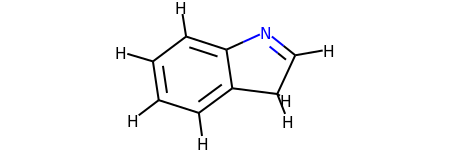

In [65]:
m

In [ ]:
for name, smile in molecules.items():
    # if name != '1,9-dichlorononane':
    #     continue
    m = Chem.MolFromSmiles(smile)
    m = Chem.AddHs(m)
    Chem.EmbedMultipleConfs(m, numConfs=10, randomSeed=0xf00d, 
                            useExpTorsionAnglePrefs=True,
                            useBasicKnowledge=True)
    p = py3Dmol.view(width=400,height=400)
    for confId in range(10):
        drawit2(m,p,confId)
    p.show()

##  Get molecular size of a test molecule

In [29]:
%%time
# name, smiles = 'n-octane', 'CCCCCCCC'
# name, smiles = 'n-hexane', 'CCCCCC'
name, smiles = '2mIM', 'CC1=NC=CN1'
# name, smiles = '1H-indole', 'c1cc2ccccc2[nH]1'
# name, smiles = '3H-indole', 'C1C=Nc2ccccc12'
output_dir = '/home/atarzia/psp/molecule_DBs/atarzia/'
res = ercollect.rdkit_functions.calc_molecule_diameter(name, smiles, out_dir=output_dir,
                                             MW_thresh=2000, 
                                             vdwScale=0.8, 
                                             boxMargin=4.0,
                                             spacing=0.4, 
                                             show_vdw=False, plot_ellip=False,
                                             N_conformers=200)

min_min = min(res.diam1)
min_mid = min(res.diam2)
min_diam_avg = np.average(res['diam1'])
min_diam_std = np.std(res['diam1'])
mid_diam_avg = np.average(res['diam2'])
mid_diam_std = np.std(res['diam2'])
result = (min_min, min_mid, min_diam_avg, min_diam_std,
          mid_diam_avg, mid_diam_std)
print(result)    

(3.8224480585630523, 5.288224312953982, 4.051903028444203, 0.1498680180896922, 5.65922437120134, 0.2459628652324251)
CPU times: user 4min 15s, sys: 3.36 s, total: 4min 18s
Wall time: 3min 27s


In [ ]:
X = [4, 8]
Y = [5.164421506520693, 5.311863731012572]

X = [4, 8]
Y = [5.571896095439993, 5.571896095439993]

## visualise the ellipsoid around a desired molecule

In [54]:
molecules = {'n-octane': 'CCCCCCCC'}
#              'ethanol': 'CCO',
#              'n-hexane': 'CCCCCC',
#              'cyclohexane': 'C1CCCCC1',
#              'para-xylene': 'Cc1ccc(C)cc1',
#              'n-decanoic acid': 'CCCCCCCCCC(=O)O'}
diameters = {}
for name in molecules.keys():
    diameters[name] = 0
output_dir = '/home/atarzia/psp/molecule_param/'

In [44]:
smiles = molecules['n-octane']
m = Chem.MolFromSmiles(smiles)
m = Chem.AddHs(m)
Chem.EmbedMultipleConfs(m, numConfs=4,
                        useExpTorsionAnglePrefs=True,
                        useBasicKnowledge=True)
p = py3Dmol.view(width=400,height=400)
for confId in range(4):
    drawit2(m,p,confId)
p.show()
v= PyMol.MolViewer()
v.DeleteAll()
for cid in range(4): 
    v.ShowMol(m,confId=cid,name='Conf-%d'%cid,showOnly=False)
v.server.do('set grid_mode, on')
v.server.do('ray')

You appear to be running in JupyterLab. You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [56]:
# molecules = {'n-decanoic_acid': 'CCCCCCCCCC(=O)O'}
os.system('rm '+output_dir+list(molecules.keys())[0]+'_diam_result.csv')
ercollect.rdkit_functions.calc_molecule_diameters(molecules, out_dir=output_dir,
                                        MW_thresh=2000, 
                                        rerun=True, vdwScale=0.8, 
                                        boxMargin=8.0,
                                        spacing=0.6, show_vdw=True, plot_ellip=False,
                                        N_conformers=1)

molecule: n-octane : SMILES: CCCCCCCC
1 out of 1 done


# Debug and modification of RS database 

In [ ]:
from rxn_syst import reaction, yield_rxn_syst, collect_RS_molecule_properties
import glob
directory = '/home/atarzia/psp/screening_results/biomin_search/'
molecule_db_dir = '/home/atarzia/psp/molecule_DBs/atarzia/'
molecules = glob.glob(molecule_db_dir+'ATRS_*.gpkl')
count = 0
rs_pkls_done = []

In [ ]:
for rs in yield_rxn_syst(directory):
    count += 1
    if rs.pkl in rs_pkls_done:
        continue
    rs_pkls_done.append(rs.pkl)
    if rs.skip_rxn is True:
        continue
    print('-----', count, '---', rs.pkl)
    if rs.components is None:
        continue
    for m in rs.components:
        print(m.name, m.role)
        print(m.SMILES)
        try:
            print(m.pkl)
        except AttributeError:
            print('no pkl')
    rs.mol_collected = False
    collect_RS_molecule_properties(rs=rs, output_dir=directory,
                                   mol_db_dir=molecule_db_dir,
                                   molecules=molecules, count=0,
                                   react_syst_files=[])
    for m in rs.components:
        print(m.pkl)

# Debug and modification of molecule database

In [ ]:
from ercollect.PUBCHEM_IO import get_logP_from_name, get_complexity_from_name, get_IUPAC_from_name
from ercollect.molecule import yield_molecules, load_molecule
directory = '/home/atarzia/psp/molecule_DBs/atarzia/'

In [ ]:
for j, i in enumerate(yield_molecules(directory=directory)):
    if i.name == "cocaine":
        print(i.name)
        break

In [ ]:
i.rs_pkls

In [ ]:
i.mol

In [ ]:
i.mol

In [ ]:
caught = []
for j, i in enumerate(yield_molecules(directory=directory)):
    print('doing -----', j)
    if '\n' in str(i.SMILES):
        print(i.name)
        print('SMILES', i.SMILES)
        caught.append(i)

In [ ]:
print(len(caught))
for ca in caught:
    print(ca.name, ca.pkl)
    print(ca.SMILES)
    splits = ca.SMILES.split('\n')
    print(splits)
    break

In [ ]:
from collections import Counter
print(Counter([i.DB for i in caught]))

## molecule list debug

In [ ]:
# list of molecules of interest
molecules = ['4-hydroxy-3-octaprenylbenzoate', '2-dehydro-3-deoxy-L-fuconate', 'dTDP-4-dehydro-6-deoxy-alpha-D-glucopyranose', '2-oxopentanoate', 
             'L-methionine-7-amido-4-methylcoumarin', 'CpU', 'phenylpyruvate', 'nicotinate mononucleotide', 'asparagine', "thymidine 5'-monophosphate", 
             'beta-citryl-L-glutamate', 'L-lysine ethyl ester']

In [ ]:
# find rxn system files and molecule files for each molecule
mol_dir = '/home/atarzia/psp/molecule_DBs/atarzia/'
mol_dict = {}

for mol in molecules:
    print(mol)
    for m in yield_molecules(directory=mol_dir):
        if mol == m.name or mol == m.iupac_name:
            print('found')
            mol_dict[mol] = (m.pkl, m.rs_pkls)

In [ ]:
from BRENDA_IO import *
mol = '2-dehydro-3-deoxy-L-fuconate'
mol_val = mol_dict[mol]
chebiID = get_chebiID_for_BRENDA(mol, 1)
print(mol, '-- chebiID =', chebiID)

In [ ]:
from molecule import *
from CHEBI_IO import *
molec = molecule(mol, 'reactant', 'BRENDA', chebiID)
molec.chebiID = molec.DB_ID
get_cmpd_information(molec)

print('this result is not right, the chebiID that was input links to a molecule!')

In [ ]:
import DB_functions

In [ ]:
DB_prop = DB_functions.get_DB_prop('CHEBI')
compounds_file = DB_prop[0]+DB_prop[1]['cmpds_file']
names_file = DB_prop[0]+DB_prop[1]['names_file']
structures_file = DB_prop[0]+DB_prop[1]['strct_file']

# set name by searching compound file
res = search_for_compound_by_id(compounds_file, molec.chebiID)
print(res)
ID, parent_id, name, star = res
if parent_id != 'null':
    print('oi')

In [ ]:
# get structure using CHEBI ID
# structures.csv - read in, get COMPOUND ID match then extract the
# get SMILES
structure, s_type = get_structure(structures_file, molec.chebiID)
print(structure, s_type)
print('this result is not right, the chebiID that was input links to a molecule!')

In [ ]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule
res = molecule.search(mol)  # 'viagra')
# guaiacol

In [ ]:
print('there are', len(res), 'top search candidates:')
for i in range(len(res)):
    print('option:', i, 'name:', res[i]['pref_name'])
    print([res[i]['molecule_synonyms'][j]['synonyms'] for j in range(len(res[i]['molecule_synonyms']))])

In [ ]:
if structure is not None:
    # is structure a MolBlock or Smiles
    if s_type == 'mol':
        # convert structure to SMILEs
        rdkitmol = Chem.MolFromMolBlock(structure)
        if rdkitmol is None:
            print('structure could not be deciphered')
            smile = None
            molec.SMILES = smile
            molec.mol = None
            print('probably a polymeric structure - skipping.')
        else:
            rdkitmol.Compute2DCoords()
            smile = Chem.MolToSmiles(rdkitmol)
            molec.SMILES = smile
            # remove molecules with generalised atoms
            if '*' in smile:
                molec.mol = None
            else:
                molec.mol = rdkitmol
    elif s_type == 'SMILES':
        smile = structure
        rdkitmol = Chem.MolFromSmiles(smile)
        if rdkitmol is None:
            print('structure could not be deciphered')
            molec.SMILES = smile
            molec.mol = None
        else:
            rdkitmol.Compute2DCoords()
            molec.SMILES = smile
            # remove molecules with generalised atoms
            if '*' in smile:
                molec.mol = None
            else:
                molec.mol = rdkitmol
    elif s_type == 'InChI':
        rdkitmol = Chem.MolFromInchi(structure)
        rdkitmol.Compute2DCoords()
        smile = Chem.MolToSmiles(rdkitmol)
        molec.SMILES = smile
        # remove molecules with generalised atoms
        if '*' in smile:
            molec.mol = None
        else:
            molec.mol = rdkitmol
    elif s_type == 'InChIKey':
        rdkitmol = Chem.MolFromInchi(structure)
        rdkitmol.Compute2DCoords()
        smile = None
        molec.SMILES = smile
        molec.mol = None
        print('molecule given as InChIKey - ambiguous')
        print('probably a generic structure - skipping.')
else:
    smile = None
    molec.SMILES = smile
    molec.mol = None
    print('molecule does not have recorded structure in CHEBI DB')
    print('probably a generic structure - skipping.')


In [ ]:
# test libChEBIpy (https://github.com/libChEBI/libChEBIpy)
from libchebipy import ChebiEntity
print(molec.chebiID)
entity = ChebiEntity(molec.chebiID) 

In [ ]:
entity = ChebiEntity('1000') 

In [ ]:
entity.get_smiles()

In [ ]:
if entity['_ChebiEntity__all_ids'] is None:
    print('hey')

In [ ]:
entity.get_formula()

In [ ]:
entity.get_smiles()

In [ ]:
import libchebipy._parsers as parsers
#print(parsers.get_names(37448))
print(parsers.get_smiles('37448'))

##  Random Code

In [ ]:
If you want all possible names for a molecule (from the SMILES string) using Python:

>>> from cinfony import webel, pybel
>>> mol = pybel.readstring("smi", "C(=O)C=C")
>>> name = webel.Molecule(mol).write("names")
>>> print(name)

['prop-2-enal', 'Acrolein', ..